# Installing the Packages

In [1]:
!pip install snscrape

In [3]:
!pip install wordcloud

In [5]:
!pip install emot

In [20]:
#libraries needed
import pandas as pd
import snscrape.modules.twitter as sntwitter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
# nltk.download('stopwords') #run once and comment it out to avoid it downloading multiple times
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

import string
import re
import textblob
from textblob import TextBlob

from wordcloud import WordCloud, STOPWORDS
from emot.emo_unicode import UNICODE_EMOJI

porter = PorterStemmer()

lemmatizer = WordNetLemmatizer() 

from wordcloud import ImageColorGenerator
from PIL import Image

import warnings
%matplotlib inline

[nltk_data] Downloading package stopwords to C:\Users\Visacheck
[nltk_data]     Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


# Data gathering

In [10]:
# creating a query for the search

# query = "(Peter Obi OR Tinubu OR Atiku OR #PeterObiForPresident2023 OR #TinubuForPresident2023 OR #AtikuForPresident2023 OR #BAT2023 OR #Obi2023 OR #Atiku2023 OR #OBIdient OR #Atikulated OR Batified OR PDP OR APC OR LP OR LABOUR PARTY) since:2022-01-01 until:2022-11-30"
# tweets = []
# for i, tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
#     if i>20000:
#         break
#     else:
#         tweets.append([tweet.date, tweet.id, tweet.url, tweet.user.username, tweet.sourceLabel, tweet.user.location, tweet.content, tweet.likeCount, tweet.retweetCount])
# df = pd.DataFrame(tweets, columns = ['Date', 'ID', 'url', 'username', 'source', 'location', 'tweet', 'num_of_likes', 'num_of_retweet'])
# df.to_csv('raw_tweets.csv', mode = 'a')

In [11]:
df =  pd.read_csv('raw_tweets.csv', encoding = 'unicode_escape')
df.head()

,Unnamed: 0,Date,ID,url,username,source,location,tweet,num_of_likes,num_of_retweet
0,0,2022-11-29 23:52:54+00:00,1597740415742283776,https://twitter.com/joan_smilez1/status/159774...,joan_smilez1,Twitter for Android,NaN,@Blessyn_Dion @OkeyBakassy If Peter Obi is emp...,3,0
1,1,2022-11-29 23:52:05+00:00,1597740211835838464,https://twitter.com/petraek09/status/159774021...,petraek09,Twitter for Android,NaN,@n6oflife6 @PeterObi We need to start referrin...,0,0
2,2,2022-11-29 23:49:02+00:00,1597739444748292096,https://twitter.com/FDipio/status/159773944474...,FDipio,Twitter for Android,Yenagoa,@PeterObi Baba that forgot to see his Labour p...,2,0
3,3,2022-11-29 23:46:22+00:00,1597738771096948737,https://twitter.com/Dr_chazduke/status/1597738...,Dr_chazduke,Twitter for iPhone,United Kingdom,Bola Tinubu and APC can pay anything to have h...,42,20
4,4,2022-11-29 23:40:18+00:00,1597737245590503424,https://twitter.com/DearestJessica_/status/159...,DearestJessica_,Twitter for Android,"Co-founder, WCRLO",Obi all the way..............\n\nNote:\nObidie...,1,0


# Precleaning

In [12]:
df.shape

(20001, 10)

In [13]:
df.columns

Index(['Unnamed: 0', 'Date', 'ID', 'url', 'username', 'source', 'location',
       'tweet', 'num_of_likes', 'num_of_retweet'],
      dtype='object')

In [15]:
#dropping unnamed column
to_drop = ['Unnamed: 0']
 
df.drop(to_drop, inplace=True, axis=1)

df.head()

,Date,ID,url,username,source,location,tweet,num_of_likes,num_of_retweet
0,2022-11-29 23:52:54+00:00,1597740415742283776,https://twitter.com/joan_smilez1/status/159774...,joan_smilez1,Twitter for Android,NaN,@Blessyn_Dion @OkeyBakassy If Peter Obi is emp...,3,0
1,2022-11-29 23:52:05+00:00,1597740211835838464,https://twitter.com/petraek09/status/159774021...,petraek09,Twitter for Android,NaN,@n6oflife6 @PeterObi We need to start referrin...,0,0
2,2022-11-29 23:49:02+00:00,1597739444748292096,https://twitter.com/FDipio/status/159773944474...,FDipio,Twitter for Android,Yenagoa,@PeterObi Baba that forgot to see his Labour p...,2,0
3,2022-11-29 23:46:22+00:00,1597738771096948737,https://twitter.com/Dr_chazduke/status/1597738...,Dr_chazduke,Twitter for iPhone,United Kingdom,Bola Tinubu and APC can pay anything to have h...,42,20
4,2022-11-29 23:40:18+00:00,1597737245590503424,https://twitter.com/DearestJessica_/status/159...,DearestJessica_,Twitter for Android,"Co-founder, WCRLO",Obi all the way..............\n\nNote:\nObidie...,1,0


In [16]:
#checking for empty columns

df.isna().sum()

Date                 0
ID                   0
url                  0
username             0
source               0
location          6164
tweet                0
num_of_likes         0
num_of_retweet       0
dtype: int64

seeing that location has the most empty column,we fill it up

In [17]:
df['location'] = df['location'].fillna('Unknown')

# Data cleaning

This involves this neccessay steps before carrying out the sentiment analysis To remove the stop words Removing tags, url links and other unnecessary words Tokenizing the words Lemmitizing words

In [25]:
#ensuring that the stopwords are in english
eng_stop_words = list(stopwords.words('english'))


In [26]:
emoji = list(UNICODE_EMOJI.keys())

In [27]:
# function for preprocessing tweet in preparation for sentiment analysis
def ProcessedTweets(text):
    #changing tweet text to small letters
    text = text.lower()
    # Removing @ and links 
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", text).split())
    # removing repeating characters
    text = re.sub(r'\@\w+|\#\w+|\d+', '', text)
    # removing punctuation and numbers
    punct = str.maketrans('', '', string.punctuation+string.digits)
    text = text.translate(punct)
    # tokenizing words and removing stop words from the tweet text
    tokens = word_tokenize(text)  
    filtered_words = [w for w in tokens if w not in eng_stop_words]
    filtered_words = [w for w in filtered_words if w not in emoji]
    # lemmetizing words
    lemmatizer = WordNetLemmatizer() 
    lemma_words = [lemmatizer.lemmatize(w) for w in filtered_words]
    text = " ".join(lemma_words)
    return text

In [30]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Visacheck
[nltk_data]     Admin\AppData\Roaming\nltk_data...


True

In [32]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to C:\Users\Visacheck
[nltk_data]     Admin\AppData\Roaming\nltk_data...


True

In [33]:
# Generate a new column called 'Processed Tweets' by applying preprocessed tweets function to the 'Tweet' column.
df['Processed_Tweets'] = df['tweet'].apply(ProcessedTweets)

In [34]:
df.head()

,Date,ID,url,username,source,location,tweet,num_of_likes,num_of_retweet,Processed_Tweets
0,2022-11-29 23:52:54+00:00,1597740415742283776,https://twitter.com/joan_smilez1/status/159774...,joan_smilez1,Twitter for Android,Unknown,@Blessyn_Dion @OkeyBakassy If Peter Obi is emp...,3,0,dion peter obi empty bulaba nonexistent pdapc ...
1,2022-11-29 23:52:05+00:00,1597740211835838464,https://twitter.com/petraek09/status/159774021...,petraek09,Twitter for Android,Unknown,@n6oflife6 @PeterObi We need to start referrin...,0,0,need start referring peter obi lp would greatl...
2,2022-11-29 23:49:02+00:00,1597739444748292096,https://twitter.com/FDipio/status/159773944474...,FDipio,Twitter for Android,Yenagoa,@PeterObi Baba that forgot to see his Labour p...,2,0,baba forgot see labour party gubernatorial can...
3,2022-11-29 23:46:22+00:00,1597738771096948737,https://twitter.com/Dr_chazduke/status/1597738...,Dr_chazduke,Twitter for iPhone,United Kingdom,Bola Tinubu and APC can pay anything to have h...,42,20,bola tinubu apc pay anything half organic supp...
4,2022-11-29 23:40:18+00:00,1597737245590503424,https://twitter.com/DearestJessica_/status/159...,DearestJessica_,Twitter for Android,"Co-founder, WCRLO",Obi all the way..............\n\nNote:\nObidie...,1,0,obi way note obidient organic movement formed ...


In [36]:
df['Processed_Tweets'].head()

0    dion peter obi empty bulaba nonexistent pdapc ...
1    need start referring peter obi lp would greatl...
2    baba forgot see labour party gubernatorial can...
3    bola tinubu apc pay anything half organic supp...
4    obi way note obidient organic movement formed ...
Name: Processed_Tweets, dtype: object

In [39]:
df['tweet'].duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
19996    False
19997    False
19998    False
19999    False
20000    False
Name: tweet, Length: 20001, dtype: bool

In [40]:
# Lowercase 
df['tweet']=df['tweet'].str.lower()
df.head()

,Date,ID,url,username,source,location,tweet,num_of_likes,num_of_retweet,Processed_Tweets
0,2022-11-29 23:52:54+00:00,1597740415742283776,https://twitter.com/joan_smilez1/status/159774...,joan_smilez1,Twitter for Android,Unknown,@blessyn_dion @okeybakassy if peter obi is emp...,3,0,dion peter obi empty bulaba nonexistent pdapc ...
1,2022-11-29 23:52:05+00:00,1597740211835838464,https://twitter.com/petraek09/status/159774021...,petraek09,Twitter for Android,Unknown,@n6oflife6 @peterobi we need to start referrin...,0,0,need start referring peter obi lp would greatl...
2,2022-11-29 23:49:02+00:00,1597739444748292096,https://twitter.com/FDipio/status/159773944474...,FDipio,Twitter for Android,Yenagoa,@peterobi baba that forgot to see his labour p...,2,0,baba forgot see labour party gubernatorial can...
3,2022-11-29 23:46:22+00:00,1597738771096948737,https://twitter.com/Dr_chazduke/status/1597738...,Dr_chazduke,Twitter for iPhone,United Kingdom,bola tinubu and apc can pay anything to have h...,42,20,bola tinubu apc pay anything half organic supp...
4,2022-11-29 23:40:18+00:00,1597737245590503424,https://twitter.com/DearestJessica_/status/159...,DearestJessica_,Twitter for Android,"Co-founder, WCRLO",obi all the way..............\n\nnote:\nobidie...,1,0,obi way note obidient organic movement formed ...


In [42]:
# extracting the parties: apc, pdp, labour party and the 3 top candidate name into new columns
def extract_apc(n):
  n = str(n)
  resp = n.lower().find("apc")
  if resp != -1:
    return "APC"
  else:
    return None

def extract_pdp(n):
  n = str(n)
  resp = n.lower().find("pdp")
  if resp != -1:
    return "PDP"
  else:
    return None

def extract_labour(n):
  n = str(n)
  resp = n.lower().find("labour party")
  if resp != -1:
    return "Labour Party"
  else:
    return None

def extract_obi(n):
  n = str(n)
  resp = n.lower().find("obi")
  if resp != -1:
    return "Peter Obi"
  else:
    return None

def extract_atiku(n):
  n = str(n)
  resp = n.lower().find("atiku")
  if resp != -1:
    return "Atiku"
  else:
    return None

def extract_tinubu(n):
  n = str(n)
  resp = n.lower().find("tinubu")
  if resp != -1:
    return "Tinubu"
  else:
    return None

In [43]:
#applying the function
df['Obi'] = df['tweet'].apply(extract_obi) 
df['labour'] = df['tweet'].apply(extract_labour) 
df['pdp'] = df['tweet'].apply(extract_pdp) 
df['apc'] = df['tweet'].apply(extract_apc) 
df['atiku'] = df['tweet'].apply(extract_atiku) 
df['tinubu'] = df['tweet'].apply(extract_tinubu) 

In [44]:
# replacing empty values with Empty
df['Obi'] = df['Obi'].fillna('Empty')
df['labour'] = df['labour'].fillna('Empty')
df['pdp'] = df['pdp'].fillna('Empty')
df['apc'] = df['apc'].fillna('Empty')
df['atiku'] = df['atiku'].fillna('Empty')
df['tinubu'] = df['tinubu'].fillna('Empty')

In [45]:
# convert the tweet text into a string separate with " "
tweets_string = df['Processed_Tweets'].tolist()
tweets_string = " ".join(tweets_string)

In [46]:
df.to_csv('cleaned_raw_data.csv') #write dataframe into csv file

# Sentimental Analysis

In [47]:
#get subjectivity and polarity of tweets with a function
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
#get polarity with a function
def getPolarity(text):
    return TextBlob(text).sentiment.polarity
df['Subjectivity'] = df['Processed_Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Processed_Tweets'].apply(getPolarity)
# df.drop('Tweets', axis=1).head() #shows polarity and subjectivity of each tweet and drops the uncleaned tweets column

In [48]:
df.head()

,Date,ID,url,username,source,location,tweet,num_of_likes,num_of_retweet,Processed_Tweets,Obi,labour,pdp,apc,atiku,tinubu,Subjectivity,Polarity
0,2022-11-29 23:52:54+00:00,1597740415742283776,https://twitter.com/joan_smilez1/status/159774...,joan_smilez1,Twitter for Android,Unknown,@blessyn_dion @okeybakassy if peter obi is emp...,3,0,dion peter obi empty bulaba nonexistent pdapc ...,Peter Obi,Empty,Empty,APC,Empty,Empty,0.425000,-0.237500
1,2022-11-29 23:52:05+00:00,1597740211835838464,https://twitter.com/petraek09/status/159774021...,petraek09,Twitter for Android,Unknown,@n6oflife6 @peterobi we need to start referrin...,0,0,need start referring peter obi lp would greatl...,Peter Obi,Empty,Empty,Empty,Empty,Empty,0.750000,0.800000
2,2022-11-29 23:49:02+00:00,1597739444748292096,https://twitter.com/FDipio/status/159773944474...,FDipio,Twitter for Android,Yenagoa,@peterobi baba that forgot to see his labour p...,2,0,baba forgot see labour party gubernatorial can...,Peter Obi,Labour Party,Empty,Empty,Empty,Empty,0.514286,-0.053571
3,2022-11-29 23:46:22+00:00,1597738771096948737,https://twitter.com/Dr_chazduke/status/1597738...,Dr_chazduke,Twitter for iPhone,United Kingdom,bola tinubu and apc can pay anything to have h...,42,20,bola tinubu apc pay anything half organic supp...,Peter Obi,Labour Party,Empty,APC,Empty,Tinubu,0.422222,0.244444
4,2022-11-29 23:40:18+00:00,1597737245590503424,https://twitter.com/DearestJessica_/status/159...,DearestJessica_,Twitter for Android,"Co-founder, WCRLO",obi all the way..............\n\nnote:\nobidie...,1,0,obi way note obidient organic movement formed ...,Peter Obi,Labour Party,Empty,Empty,Empty,Empty,0.000000,0.000000


In [49]:
#create a function to check negative, neutral and positive analysis
def getAnalysis(score):
    if score<0:
        return 'Negative'
    elif score ==0:
        return 'Neutral'
    else:
        return 'Positive'
    
df['Analysis'] = df['Polarity'].apply(getAnalysis)

In [50]:
df.head()

,Date,ID,url,username,source,location,tweet,num_of_likes,num_of_retweet,Processed_Tweets,Obi,labour,pdp,apc,atiku,tinubu,Subjectivity,Polarity,Analysis
0,2022-11-29 23:52:54+00:00,1597740415742283776,https://twitter.com/joan_smilez1/status/159774...,joan_smilez1,Twitter for Android,Unknown,@blessyn_dion @okeybakassy if peter obi is emp...,3,0,dion peter obi empty bulaba nonexistent pdapc ...,Peter Obi,Empty,Empty,APC,Empty,Empty,0.425000,-0.237500,Negative
1,2022-11-29 23:52:05+00:00,1597740211835838464,https://twitter.com/petraek09/status/159774021...,petraek09,Twitter for Android,Unknown,@n6oflife6 @peterobi we need to start referrin...,0,0,need start referring peter obi lp would greatl...,Peter Obi,Empty,Empty,Empty,Empty,Empty,0.750000,0.800000,Positive
2,2022-11-29 23:49:02+00:00,1597739444748292096,https://twitter.com/FDipio/status/159773944474...,FDipio,Twitter for Android,Yenagoa,@peterobi baba that forgot to see his labour p...,2,0,baba forgot see labour party gubernatorial can...,Peter Obi,Labour Party,Empty,Empty,Empty,Empty,0.514286,-0.053571,Negative
3,2022-11-29 23:46:22+00:00,1597738771096948737,https://twitter.com/Dr_chazduke/status/1597738...,Dr_chazduke,Twitter for iPhone,United Kingdom,bola tinubu and apc can pay anything to have h...,42,20,bola tinubu apc pay anything half organic supp...,Peter Obi,Labour Party,Empty,APC,Empty,Tinubu,0.422222,0.244444,Positive
4,2022-11-29 23:40:18+00:00,1597737245590503424,https://twitter.com/DearestJessica_/status/159...,DearestJessica_,Twitter for Android,"Co-founder, WCRLO",obi all the way..............\n\nnote:\nobidie...,1,0,obi way note obidient organic movement formed ...,Peter Obi,Labour Party,Empty,Empty,Empty,Empty,0.000000,0.000000,Neutral


In [52]:
df.to_csv('new_raw_data.csv') #write dataframe into csv file

In [51]:
df['Analysis'].value_counts() #shows the counts of tweets' polarity

Positive    9217
Neutral     7054
Negative    3730
Name: Analysis, dtype: int64

# Visualization

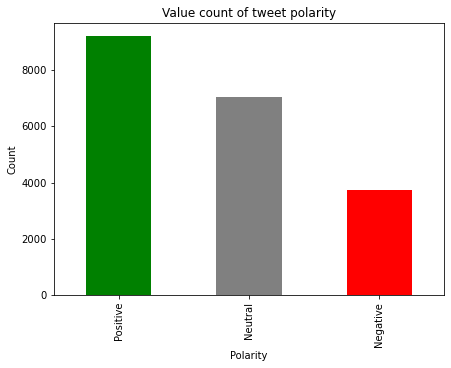

<Figure size 432x288 with 0 Axes>

In [54]:
#plot a bar graph to show count of tweet sentiment
fig1 = plt.figure(figsize=(7,5))
color = ['green','grey','red']
df['Analysis'].value_counts().plot(kind='bar',color = color)
plt.title('Value count of tweet polarity')
plt.ylabel('Count')
plt.xlabel('Polarity')
plt.grid(False)
plt.show()

#saving the image
plt.savefig('election_fig1.png')

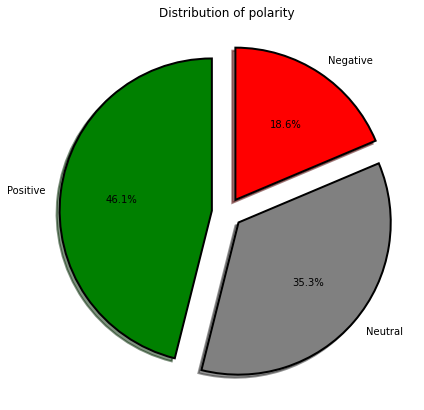

In [57]:
#pie chart to show percentage distribution of polarity
fig = plt.figure(figsize=(7,7))
colors = ('green', 'grey', 'red')
wp={'linewidth':2, 'edgecolor': 'black'}
tags=df['Analysis'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors=colors, 
         startangle=90, wedgeprops=wp, explode=explode, label='')
plt.title('Distribution of polarity')

#saving the image
plt.savefig('election_fig2.png')

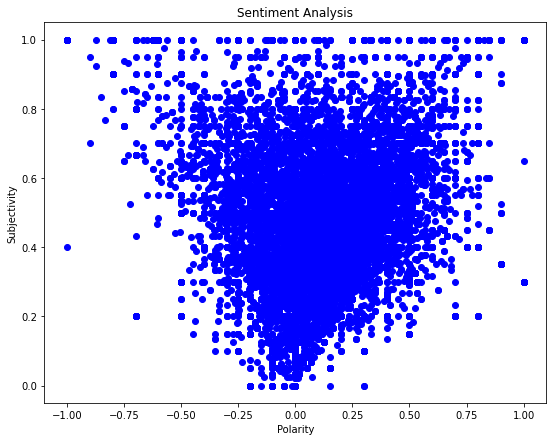

<Figure size 432x288 with 0 Axes>

In [61]:
#plot the polarity and subjectivity on a scatter plot
plt.figure(figsize=(9,7))
for i in range(0,df.shape[0]):
    plt.scatter(df['Polarity'][i],df['Subjectivity'][i], color='blue')
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

#saving the image
plt.savefig('election_fig3.png')

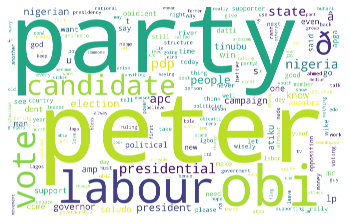

<Figure size 432x288 with 0 Axes>

In [76]:
# Instantiate the Twitter word cloud object
w_cloud = WordCloud(collocations = False,max_words=200, background_color = 'white', width = 8000, height = 5000).generate(tweets_string)

# Display the generated Word Cloud
plt.imshow(w_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.savefig('election_fig4.png')

In [63]:
plt.savefig('election_fig4.png')

<Figure size 432x288 with 0 Axes>

In [64]:
#break each tweet sentence into words
sentences = []
for word in df['Processed_Tweets']:
    sentences.append(word)
sentences
lines = list()
for line in sentences:
    words = line.split()
    for w in words:
        lines.append(w)
lines[:10] #shows first 10 words in the first tweet

['dion',
 'peter',
 'obi',
 'empty',
 'bulaba',
 'nonexistent',
 'pdapc',
 'party',
 'barren',
 'bootless']

# Conclusion

The total tweets scrapped was 20001.

We used a library called TextBolob to detect the subjectivity or polarity of a tweet. It uses Natural Language ToolKit (NLTK). The Subjectivity shows the amount of personal opinion in a sentence. Its score lies between 0 and 1. If a tweet has high subjectivity i.e. close to 1, it means the tweet contains more of a personal opinion than factual information. The polarity score lies between (-1 to 1) where -1 identifies the most negative words and 1 identifies the most positive words.

We created a function that gets the subjectivity and polarity of each tweet and saves them to new columns with the names Subjectivity and Polarity respectively

Overall, many people feel positive about the election despite the general believe of "the votes don't count".Over 40% of tweets indicate there is still hope for the election. 

Peter Obi, one of the candidates seems to be the most talked about as shown in the wordcloud.This could be a result of historic data as a former gpvernor of Anambra state.